In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Algorithm

1. Initial clustering and merging:
    * identifies clusters based on spatio-temporal nearness
        * events must first be close in time $\to$ identifies many small clusters
        * adding a new event must be close to the statistical center of a cluster
    * adjacent clusters are merged when they not sufficiently separated 

2. Remaining clusters are 
```
clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
clusters_3 = separate_embedded_clusters(clusters_2, True)
clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
clusters_4 = sorted([sorted(c) for c in clusters_4])
clusters_5 = get_iqr_trimmed_clusters(noise_arr, clusters_4, 1.5);
```

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos


* check that the newly split clusters are 
    * contain enough samples
    * $\checkmark$ ~~have a total duration longer than the threshold~~ see `get_extended_clusters`
    * $\checkmark$ ~~are not embedded within another cluster~~ possible, but unused; see `separate_embedded_clusters`
* $\checkmark$ ~~check that there are no embedded clusters~~ see `separate_embedded_clusters`
    * ~~times don't overlap~~ $\checkmark\to$ have function
    * ~~if refined clusters are embedded, check if one cluster is noise~~ ignored
* check the stddev of the refined clusters are smaller
* check on adjacent clusters
    * $\checkmark$ ~~check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median~~ see `merge_clusters_combo`
        * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
            * e.g. 
                * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
                * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
    * $\checkmark$ ~~check of the metrics for inter-subcluster gaps~~ see `merge_clusters_combo`
        * these are also clusters but unlabeled after the first round of clustering
    * **!!!** check that the identified stays during the substages are not immediately adjacent
        * _ie_ no stays should have indices like `[10, ..., 20]` followed by `[21, ..., 30]`
            * such stays are possible $\to$ but there should be a minimum travel time if the locations are distinct
## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

### From here

At this point, it seems that the basic clusters are formed. 

Next, use the IQRs of these clusters as the new bounds for extending the cluster: essentially using the extensible box method.

Note that the IQR can be larger than the allow distance threshold; the box would therefore need to be the smaller of the two but with the same mean and/or median

### Summary

1. `get_clusters_x` finds the clusters based on nearness of events in space and time
2. `merge_clusters` merges neraby clusters based on ...
3. `merge_clusters_2`  merges neraby clusters based on ...
4. `extend_clusters` extend the clusters
5. `separate_clusters` break the overlapping clusters and then re-merge
6. `merge_clusters_2` merge the separated clusters
7. `intersect` the forward and backward clusters

### Notes

Mostly, the results are good: more than 80% of the trajectories have prec and/or recall above 0.8

The main issue
* loss of precision due to non-stays being identified
    * this (loss) is increased with higher event density but compensated by an increase in recall
        * since many clusters are identified and the stay events have a higher probability of being classified as stay events.
<br/>

**TODO** since stay events are classified and not the accuracy of the stays, it would be useful to have a measure of the stay accuracy: _ie_ once a stay is identified, how much of that stay is correctly classified.

In [8]:
from helper__3stays_v3_scripts import switch_indices

In [9]:
from synthetic_data.plotting import plot_trajectory, add_plot_trajectory, add_plot_seg_boxes

In [10]:
from helper__3stays_v3_scripts__plotting import plot_cluster_boxplots, add_plot_cluster_boxplots

In [11]:
from helper__3stays_v3_scripts__eval import get_segments_scores

In [12]:
print_clusts = lambda cluster_list : [print(f"[{c[0]:4d},{c[-1]:4d}]") for c in cluster_list]
#print_ctimes = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}]") for c in cluster_list]
#print_ctdiff = lambda cluster_list : [print(f"{time_arr[c[-1]] - time_arr[c[0]]:6.3f}") for c in cluster_list]
#print_times = lambda l: list(map(lambda x: f"{x:6.3f}",l))

# Start here

In [13]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
#from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
#from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [14]:
from synthetic_data.canonical_stays import get3e, get3

In [15]:
from helper__get_clusters import get_clusters_1, get_clusters_2, get_clusters_3, get_clusters_4

In [16]:
time_thresh = 1/6
dist_thresh=0.25

In [17]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.30 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

Event frac. =  0.002
Dupli. frac. =  0.300


In [18]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.30 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

Event frac. =  0.003
Dupli. frac. =  0.300


2.4192151186447797 5.6293364796478755 -3.5413024662478043
[0] False
Failed


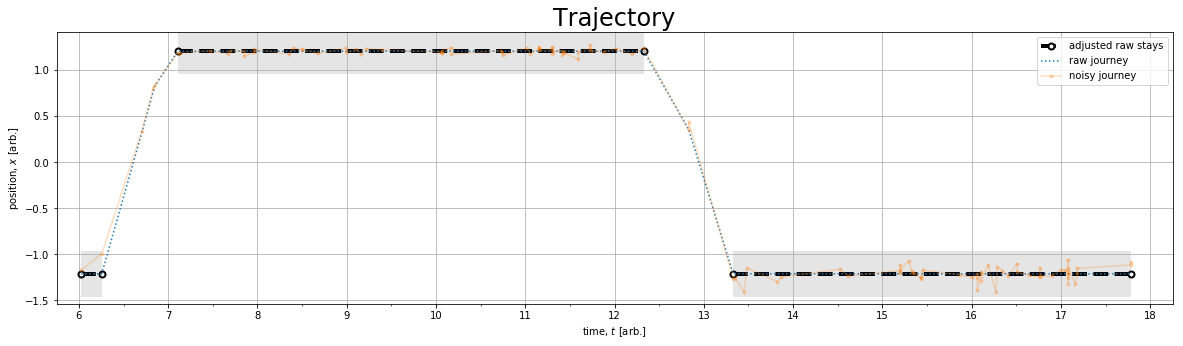

In [19]:
x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 8, 10)[0]
shift = rand_range(-5, 5, 21)[0]

print(x_dist, mid_len, shift)
val = np.random.randint(0,2,1)
print(val, bool(val))
if val:
    stays = get3(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    

continuation = True
n = 0
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        print("Failed")
        if n > 10: 
            continuation = False
        else:
            n+=1
        pass
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [20]:
from helper__3stays_v3_scripts import get_extended_clusters, separate_clusters
from helper__gaps import merge_clusters_combo
from helper__metric_box__explore import eval_synth_data

In [21]:
def split_list( l1, l2): 
    
    """
    Usage:
    split_list(range(10), list(range(4,7)))
    ([0, 1, 2, 3], [4, 5, 6], [7, 8, 9])
    """
    
    if len(l1) < len(l2):
        return ([e for e in l2 if e < min(l1)], l1, [e for e in l2 if e > max(l1)])
    else:
        return ([e for e in l1 if e < min(l2)], l2, [e for e in l1 if e > max(l2)])        

def list_intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 


def contains(a1,a2,b1,b2):
    """
    Check whether one range contains another
    """    
    return ((a1 >= b1) & (a2 <= b2))

inter_bounds = lambda p1, p2: intersecting_bounds(p1[0],p1[-1],p2[0],p2[-1])
conta_bounds = lambda p1, p2: contains(p1[0],p1[-1],p2[0],p2[-1])

def intersecting_bounds(a1,a2,b1,b2):
    """
    Check whether two ranges intersect
    
    Specifically: b1 < a1 < b2 and a2 > b2
    """

    cond1 = ((a1 >= b1) & (a1 <= b2)) | \
            ((b1 >= a1) & (b1 <= a2))    
    
    return cond1

'''
def intersecting_bounds(a1,a2,b1,b2):
    """
    Check whether two ranges intersect
    
    Specifically: b1 < a1 < b2 and a2 > b2
    """
    print(a1,a2,b1,b2)
    
    print((a1 >  b1), (a1 <= b2), (a2 >= b2))
    print((a1 >= b1), (a1 <  b2), (a2 >  b2))
    
    cond1 = (((a1 >  b1) & (a1 < b2)) & (a2 > b2)) | \
             (((a1 > b1) & (a1 < b2)) & (a2 > b2))
    return cond1
'''

def get_sorted_keys(clusts):
    d = {}
    for n, c in enumerate(clusts):
        d[n] = len(c)

    return [k for k, v in sorted(d.items(), key=lambda item: item[1])]

def check_intersecting_clusters_inds(clusters):
    m = 0
    while (m < len(clusters)):
        # Biggest cluster
        c1 = clusters[m]
        n = m+1
        while (n < len(clusters)):

            if n == m:
                n+=1
                continue

            c2 = clusters[n]
            if inter_bounds(c1,c2):
                return True, m,n
            else:
                n+=1
        m+=1
    return False, 999, 999

def check_intersecting_clusters(clusters):
    
    result, _ , _ = check_intersecting_clusters_inds(clusters)
 
    return result

def separate_clusters_hier(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_clusters_hier(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if verbose: print(result)    
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        
        if verbose: print(len(new_clusts))
        if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()
        
    return new_clusts

In [22]:
from helper__metric_box__explore import get_iqr_mask

In [23]:
def contiguous_sublists(lst1, lst2): 
    """
    Split intersecting and interleaved lists 
    into maximal contiguous sublists
    """
    #print(lst1, lst2)
    # Gather all unique elements together and order
    lst3 = sorted(list(set(lst1+lst2)))

    # Classifying function according to origin and intersections
    def get_flag(e):
        if (e in lst1) & (e in lst2):
            return 0
        elif (e in lst1):
            return 1
        else:
            return 2
    
    # output list
    all_lists = []
    
    # Initializations
    e = lst3[0]    
    flag = get_flag(e)
    lst = [e]
    
    # Walk through all elements
    for e in lst3[1:]:
        flag_ = get_flag(e)
        
        if flag == flag_:
            lst.append(e)
        else:
            all_lists.append(lst)
            lst = [e]
            flag = flag_
    
    # close the last list
    all_lists.append(lst)        
    
    # Sort the lists (maybe unnecessary)
    #all_lists = sorted([l for l in all_lists if l != []])
    
    return all_lists    

In [24]:
def separate_embedded_clusters(clusters, verbose=False):
    """
    
    Test:
    clusts = [list(range(5)), list(range(2,4)), list(range(8)), list(range(4,8)), list(range(6,10))]
    separate_embedded_clusters(clusts)
    [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]
    """    
    # Check if any clusters intersect
    new_clusts = clusters.copy()
    
    result, m, n = check_intersecting_clusters_inds(new_clusts)
    
    if verbose: print(result)    
    
    if result:
        if verbose: print(m, n)
    else:
        return clusters

    while result:
        
        #if verbose: print_clusts(new_clusts)
        if verbose: print(len(new_clusts))
        c1 = new_clusts.pop(m)
        if m < n: 
            n-=1
        c2 = new_clusts.pop(n)

        if verbose: print(len(new_clusts))
        if verbose: print(f"{m:4d}: [{c1[0]:4d},{c1[-1]:4d}] and [{c2[0]:4d},{c2[-1]:4d}]")

        '''sc1 = set(c1)
        sc2 = set(c2)

        intersexion = sc1.intersection(sc2)

        sc1_diff = sc1.difference(intersexion)
        sc2_diff = sc2.difference(intersexion)                
        '''
        
        new_clusts.extend(contiguous_sublists(c1, c2))
        '''        
        sc1_diff, intersec, sc2_diff = split_list(c1,c2)        
        
        #sc1_diff = list(sc1_diff)
        if len(sc1_diff) > 0:
            new_clusts.append(sc1_diff)
        if verbose: print("len(sc1_diff)",len(sc1_diff))
        
        #intersexion = list(intersexion)
        if len(intersec) > 0:
            new_clusts.append(intersec)
        if verbose: print("len(intersexion)",len(intersec))
        
        #sc2_diff = list(sc2_diff)
        if len(sc2_diff) > 0:
            new_clusts.append(sc2_diff)
        if verbose: print("len(sc2_diff)",len(sc2_diff))
        '''
        if verbose: print(len(new_clusts))
        #if verbose: print_clusts(new_clusts) 
        
        result, m, n = check_intersecting_clusters_inds(new_clusts)
        if verbose: print(result,m,n)
        if verbose: print()

    return sorted(new_clusts)            

In [25]:
def get_iqr_trimmed_clusters(x_arr, clusters, iqr_factor=1.5, within=True, verbose=False):
    new_clusters = []
    for c in clusters:
        cc = get_iqr_mask(x_arr[c], c, iqr_factor, within)[0]
        
        ccc = list(range(cc[0], cc[-1]+1))
        
        if verbose: print(f"[{c[0]:4d},{c[-1]:4d}] vs. [{cc[0]:4d},{cc[-1]:4d}]")
        #f" vs. [{ccc[0]:4d},{ccc[-1]:4d}]" )

        new_clusters.append(ccc)
        
    return new_clusters

Event frac. =  0.006
Dupli. frac. =  0.300
 3.414,  3.772, -1.696
[1] True
Stage 1
6 Clusters:
[   0,  51]
[  52,  59]
[  62, 159]
[ 161, 163]
[ 164, 167]
[ 168, 296]

Stage 2
3 Clusters:
[   0,  51]
[  60, 160]
[ 168, 296]

Stage 3
False
3 Clusters:
[   0,  51]
[  60, 160]
[ 168, 296]

Stage 4
No update

Stage 5
3 Clusters:
[   0,  51]
[  60, 160]
[ 169, 296]

Predicted 3 of 3 true clusters 
	Cluster   0, [   0,  46]
		overlaps with 1 pred_cluster(s):
			[   0,  51]
			precision:  0.904;
			recall:  1.000

	Cluster   1, [  61, 159]
		overlaps with 1 pred_cluster(s):
			[  60, 160]
			precision:  0.980;
			recall:  1.000

	Cluster   2, [ 178, 296]
		overlaps with 1 pred_cluster(s):
			[ 169, 296]
			precision:  0.930;
			recall:  1.000

Stats: 
	min. precision:  0.904; min. recall:  1.000
	avg. precision:  0.938; avg. recall:  1.000
	tot. precision:  0.943; tot. recall:  1.000

Durations: 
tot. trajectory duration: 11.906 
tot. true stays duration: 10.434 (0.876%) 
tot. pred stays dura

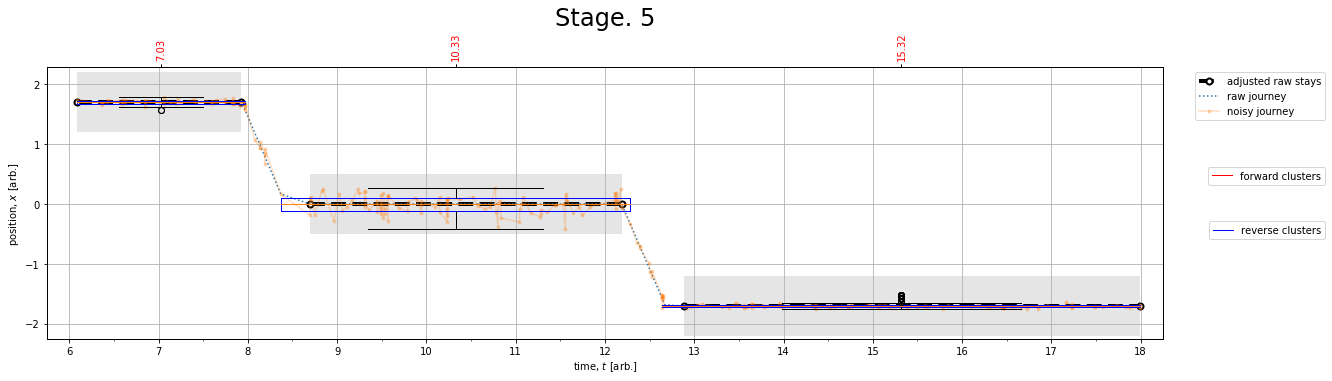

In [26]:
event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.30 #rand_range(1,0.3,0.05)[0]

print(f"Event frac. = {event_frac:6.3f}\nDupli. frac. = {duplicate_frac:6.3f}")

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}
x_dist = rand_range(0.52,5.0, 10)[0]
mid_len = rand_range(0.2, 8, 10)[0]
shift = rand_range(-5, 5, 21)[0]

print(f"{x_dist:6.3f}, {mid_len:6.3f}, {shift:6.3f}")
val = np.random.randint(0,2,1)
print(val, bool(val))
if val:
    stays = get3(x_dist, mid_len, shift)
else:
    stays = get3e(x_dist, mid_len, shift)    

continuation = True
n = 0
while continuation:
    try:
        time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
        continuation = False
    except:
        print("Failed")
        if n > 10: 
            continuation = False
        else:
            n+=1
        pass

t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

verbose = True

if verbose: print("Stage 1")
clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters_1), "Clusters:")
print_clusts(clusters_1);
print()

if verbose: print("Stage 2")
clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
print(len(clusters_2), "Clusters:")
print_clusts(clusters_2);
print()

if verbose: print("Stage 3")
#clusters_3 = separate_clusters_hier(clusters_2, True)
if clusters_2 != clusters_1:
    clusters_3 = separate_embedded_clusters(clusters_2, True)
    print(len(clusters_3), "Clusters:")
    print_clusts(clusters_3);
else: 
    print("No update")    
    clusters_3 = clusters_2.copy()
print()    
    
if verbose: print("Stage 4")
if clusters_3 != clusters_2:    
    clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
    print(len(clusters_4), "Clusters:")
    print_clusts(clusters_4);    
else: 
    print("No update")
    clusters_4 = clusters_3.copy()
print()

if verbose: print("Stage 5")
clusters_4 = sorted([sorted(c) for c in clusters_4])
iqr_trim = True
if iqr_trim:        
    clusters_5 = get_iqr_trimmed_clusters(noise_arr, clusters_4, 1.5);
    print(len(clusters_5), "Clusters:")
    print_clusts(clusters_5);
else: 
    print("No IQR-trim")
    clusters_5 = clusters_4.copy()
print()

get_segments_scores(time_arr, segments, clusters_5, True)

ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]
ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_5, switch_indices(clusters_5, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 5", fontsize=24);

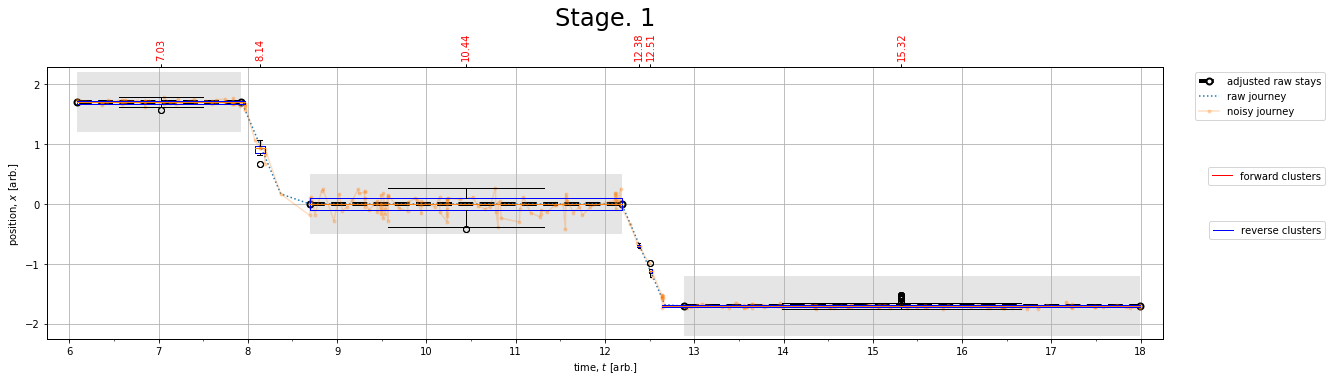

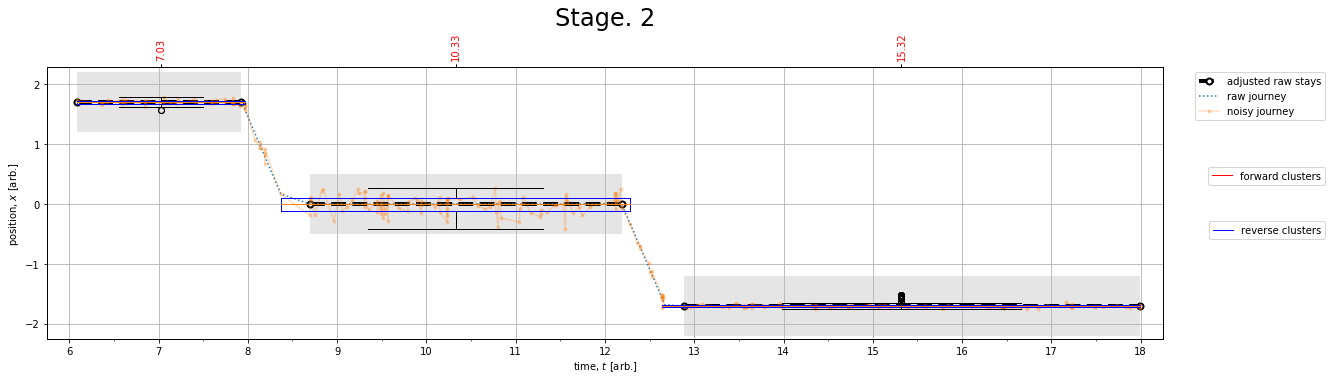

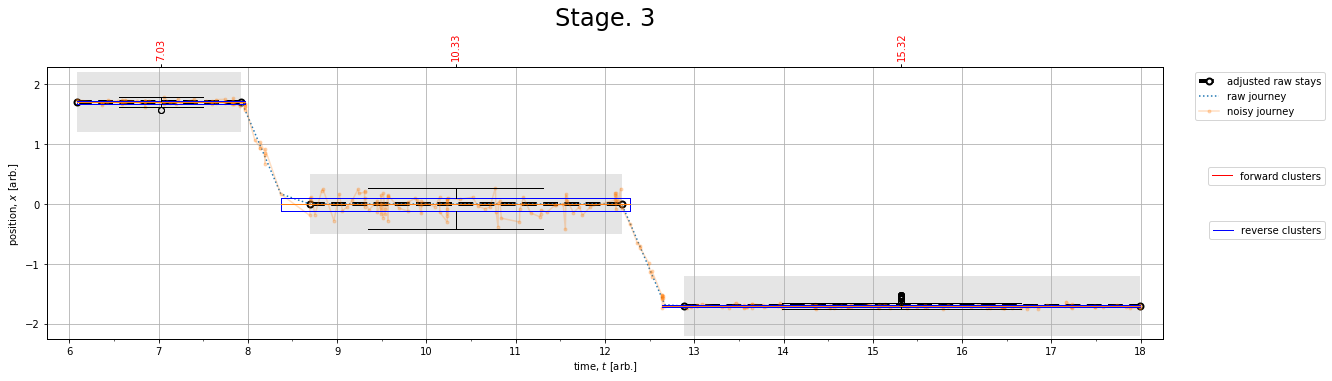

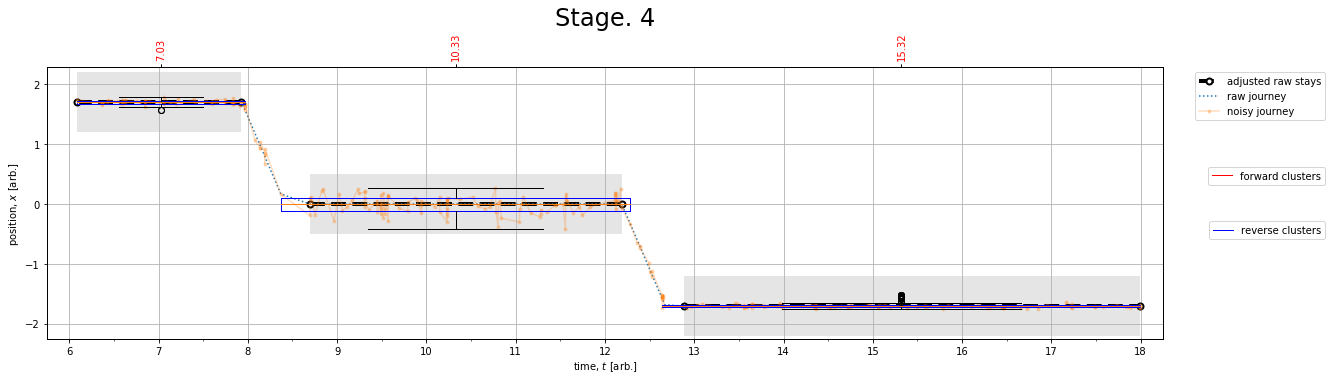

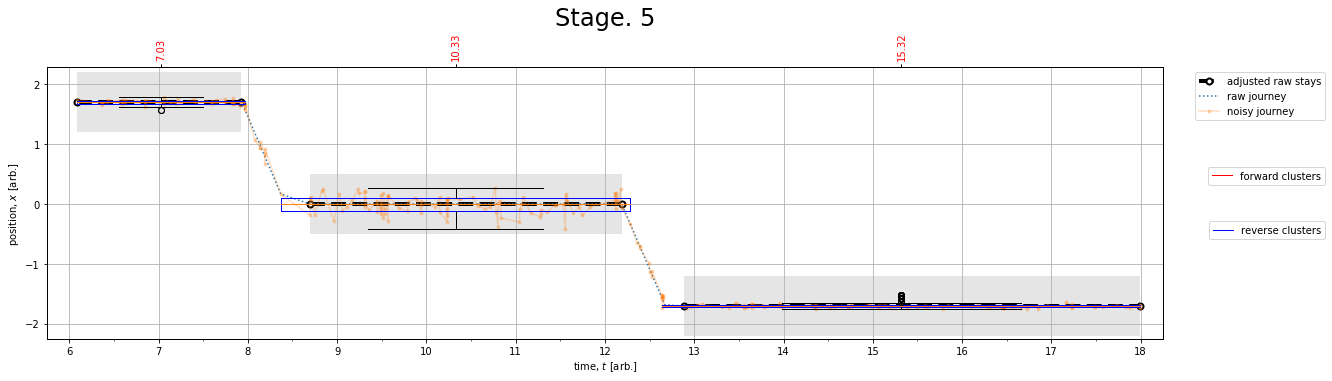

In [27]:
ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]


ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_1, switch_indices(clusters_1, time_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Stage. 1", fontsize=24)

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_2, switch_indices(clusters_2, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 2", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_3, switch_indices(clusters_3, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 3", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_4, switch_indices(clusters_4, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 4", fontsize=24);

ax = plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters_5, switch_indices(clusters_5, time_arr.shape[0]), configs)
ax.set_ylim(ylim)
ax.set_title("Stage. 5", fontsize=24);


### Notes
#### 3 clusters
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
* missing short clusters
    * these usually occur on the edges
    * if using a IQR-postfilter, many of these will get dropped
    
#### 4 clusters
* mis-identified cluster, aka "floater"
    * part of a travel
        * in the canonical 3-stays, these are always between larger stays
        * **Todo** 
            * _check if these have insufficient events with the IQR-mask_
            * _check if these have insufficient duration with the IQR-mask_            
    * seems to be short in duration
* overlapping clusters
    * embedded and also identitcal clusters
    * **Notes**
        * usually have the same median and mean ("M&M"), but not always
    * overlap on edge between two spatially close clusters
        * maybe not sharing M&M,
    * megacluster when two clusters share an $x$ (rare)
        * should be avoidable with gap durations
    * missing short clusters and overlaps/duplicates

#### Another way

In [39]:
def get_rand_canonical_vars():
    
    rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

    event_frac = rand_range(0.05,0.001, 1)[0]
    duplicate_frac = 0.30 #rand_range(1,0.3,0.05)[0]

    configs = {
        'time_thresh':1/6,
        'dist_thresh':0.5,
        'event_frac':event_frac,
        'duplicate_frac':duplicate_frac,    
        'noise_min':0.02,
        'noise_max':0.15
    }

    x_dist = rand_range(0.52,5.0, 10)[0]    
    x_dist = (-1)**np.random.randint(0,2,1)[0]*x_dist
    
    mid_len = rand_range(0.2, 8, 10)[0]
    shift = rand_range(-5, 5, 21)[0]
    
    return configs, x_dist, mid_len, shift

In [40]:
get_rand_canonical_vars()

({'time_thresh': 0.16666666666666666,
  'dist_thresh': 0.5,
  'event_frac': 0.00993921266714591,
  'duplicate_frac': 0.3,
  'noise_min': 0.02,
  'noise_max': 0.15},
 3.43791953533256,
 3.5874156224201084,
 0.6183960223997822)

In [30]:
from synthetic_data.trajectory_class import pickle_trajectory
from datetime import datetime

import os

date_tag = datetime.today().strftime('%Y%m%d')
data_dir = f"./testdata_{date_tag}_4_no_iqr_and_wi_ranges_and_wi_shift/"

data_dir = f"./testdata_training_set/"

try:
    os.makedirs(data_dir)
except OSError as e:
    print(e)

[Errno 17] File exists: './testdata_training_set/'


[{'type': 'stay',
  'loc': -4.6854080702528025,
  'start': 0.0,
  'end': 9.951545717712248,
  'slope': 0},
 {'type': 'stay',
  'loc': 3.8344802059609453,
  'start': 11.326547734589427,
  'end': 18.082008348044546,
  'slope': 0},
 {'type': 'stay',
  'loc': 2.495515556675466,
  'start': 18.298100277141174,
  'end': 24.0,
  'slope': 0}]

In [36]:
get_rand_canonical_vars() 

({'time_thresh': 0.16666666666666666,
  'dist_thresh': 0.5,
  'event_frac': 0.027284562198761575,
  'duplicate_frac': 0.3,
  'noise_min': 0.02,
  'noise_max': 0.15},
 array([2.93253751]),
 5.871359974337586,
 4.7439438114438595)

In [ ]:
total = 1000
ii = 0
while ii < total:
            
    configs, x_dist, mid_len, shift = get_rand_canonical_vars()          

    #if verbose: print(f"{x_dist:6.3f}, {mid_len:6.3f}, {shift:6.3f}")

    val = np.random.randint(0,2,1)
    if val:
        stays = get3(x_dist, mid_len, shift)
    else:
        stays = get3e(x_dist, mid_len, shift)            

    continuation = True
    m = 0
    while continuation:
        n = 0
        try:
            time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
            t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))
            stays_tag = int((x_segs.size)/3)
            continuation = False
        except:
            print("Failed at",m,n)
            if n > 10: 
                continuation = False
            else:
                n+=1
            pass

    try:
        trajectory_tag = f"trajectory_{stays_tag}stays__{ii}"
        path_to_file =  data_dir + trajectory_tag
        pickle_trajectory(time_arr, raw_arr, noise_arr, segments, path_to_file + ".pkl")
        ii+=1
    except:
        break
        
    if ii % 10 == 0:
        print(f"{ii:4d} of {total:5d}")


  10 of  1000
Failed at 0 0
Failed at 0 0
  20 of  1000
  30 of  1000
  40 of  1000
  50 of  1000
  60 of  1000
  70 of  1000
  80 of  1000
  90 of  1000
 100 of  1000
 110 of  1000
 120 of  1000
 130 of  1000
 140 of  1000
Failed at 0 0
Failed at 0 0
 150 of  1000
 160 of  1000
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
Failed at 0 0
 170 of  1000
 180 of  1000
 190 of  1000
 200 of  1000
 210 of  1000
 220 of  1000
 230 of  1000
 240 of  1000
 250 of  1000
 260 of  1000
 270 of  1000
 280 of  1000
Failed at 0 0
Failed at 0 0
 290 of  1000
Failed at 0 0
 300 of  1000
 310 of  1000
 320 of  1000
 330 of  1000
 340 of  1000
 350 of  1000
 360 of  1000
 370 of  1000
 380 of  1000
 390 of  1000
 400 of  1000
 410 of  1000
 420 of  1000
 430 of  1000
 440 of  1000
 450 of  1000
 460 o

In [33]:
import pickle

for ii in range(500, 1000):

    stays_tag = 3
    trajectory_tag = f"trajectory_{stays_tag}stays__{ii}"    
    path_to_file =  data_dir + trajectory_tag
    
    trajectory = pickle.load( open(path_to_file + ".pkl", "rb") )    
    
    segments = trajectory['segments']
    t_arr = trajectory['time_arr']
    r_arr = trajectory['raw_locs_arr']
    x_arr = trajectory['nse_locs_arr']
    t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

    ax = plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh);
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
    ax.set_xlim([5.75,18.25]);

    ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]

    plt.savefig(path_to_file + ".png")
    plt.close()
    
    if ii % 50 == 0:
        print(f"{ii:5d} of 1000")
#'''

  500 of 1000
  550 of 1000
  600 of 1000
  650 of 1000
  700 of 1000
  750 of 1000
  800 of 1000
  850 of 1000
  900 of 1000
  950 of 1000


In [ ]:
lens = []
precs = []
recs = []

precrec_limit = 0.85

ii = 0

length_criterion_break = False
iqr_trim = False
verbose = False


total = 100

while ii < total:
            
    configs, x_dist, mid_len, shift = get_rand_canonical_vars()          

    #if verbose: print(f"{x_dist:6.3f}, {mid_len:6.3f}, {shift:6.3f}")

    val = np.random.randint(0,2,1)
    if val:
        stays = get3(x_dist, mid_len, shift)
    else:
        stays = get3e(x_dist, mid_len, shift)            

    continuation = True
    m = 0
    while continuation:
        n = 0
        try:
            time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
            t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))
            continuation = False
        except:
            print("Failed at",m,n)
            if n > 10: 
                continuation = False
            else:
                n+=1
            pass

        try:

            if verbose: print("Stage 1: get mini-clusters and merging")
            clusters_1 = get_clusters_3(time_arr, noise_arr, dist_thresh, time_thresh)
            if verbose: print(len(clusters_1), "Clusters:")
            if verbose: print_clusts(clusters_1);
            if verbose: print()
            all_clusters.append(clusters_1)

            if verbose: print("Stage 2: extend clusters and IQR-filter")
            clusters_1 = sorted([sorted(c) for c in clusters_1])                        
            clusters_2 = get_extended_clusters(time_arr, noise_arr, clusters_1, time_thresh)
            if verbose: print(len(clusters_2), "Clusters:")
            if verbose: print_clusts(clusters_2);
            if verbose: print()
            all_clusters.append(clusters_2)

            if verbose: print("Stage 3: separate overlapping clusters")
            if clusters_2 != clusters_1:
                clusters_2 = sorted([sorted(c) for c in clusters_2])    
                #clusters_3 = separate_embedded_clusters(clusters_2)
                clusters_3 = separate_clusters_hier(clusters_2)
                if verbose: print(len(clusters_3), "Clusters:")
                if verbose: print_clusts(clusters_3);
            else: 
                if verbose: print("No update")    
                if verbose: clusters_3 = clusters_2.copy()
            if verbose: print()    
            all_clusters.append(clusters_3)

            if verbose: print("Stage 4: merge nearby clusters")
            if clusters_3 != clusters_2:
                clusters_3 = sorted([sorted(c) for c in clusters_3])
                clusters_4 = merge_clusters_combo(time_arr, noise_arr, clusters_3, dist_thresh, time_thresh)
                if verbose: print(len(clusters_4), "Clusters:")
                if verbose: print_clusts(clusters_4);    
            else: 
                if verbose: print("No update")
                clusters_4 = clusters_3.copy()
            if verbose: print()
            all_clusters.append(clusters_4)

            if verbose: print("Stage 5: filter regions by IQR")
            clusters_4 = sorted([sorted(c) for c in clusters_4])
            if False:#clusters_4 != clusters_3:
                clusters_5 = shift_box(time_arr, noise_arr, clusters_4, time_thresh, dist_thresh);
                if verbose: print(len(clusters_5), "Clusters:")
                if verbose: print_clusts(clusters_5);
            else: 
                if verbose: print("No update")
                clusters_5 = clusters_4.copy()
            if verbose: print()
            all_clusters.append(clusters_5)

            if verbose: print("Stage 6: shift the boxes")
            clusters_5 = sorted([sorted(c) for c in clusters_5])
            #clusters_5 = [list(range(c[0],c[-1]+1)) for c in clusters_5]
            #iqr_trim = True
            if iqr_trim:        
                clusters_6 = get_iqr_trimmed_clusters(noise_arr, clusters_5, 1.5);
                if verbose: print(len(clusters_6), "Clusters:")
                if verbose: print_clusts(clusters_6);
            else: 
                if verbose: print("No IQR-trim")
                clusters_6 = clusters_5.copy()
            if verbose: print()
            all_clusters.append(clusters_6)
                
            continuation = False
        except:                    
            print("Failed at",m)
            print(stays)                    
            if m > 10: 
                break
            else:
                m+=1
            pass

        prec, rec, conmat = eval_synth_data(segments, time_arr, all_clusters[-1])

        if (prec < precrec_limit) | (rec < precrec_limit):
            if (prec < precrec_limit) & (rec < precrec_limit):
                print("p&r low")
            elif (prec < precrec_limit):
                print("p low")
            else:
                print("r low")

            all_clusters = [
                clusters_1,
                clusters_2,
                clusters_3,
                clusters_4,
                clusters_5,
                clusters_6    
            ]

            len_all_clusts = len(all_clusters)

            fig, axs = plt.subplots(len_all_clusts,1,figsize=[20,len_all_clusts*6])

            ylim = [noise_arr.min()-2*dist_thresh, noise_arr.max()+2*dist_thresh]

            axs =axs.flatten()

            for i in range(len_all_clusts):
                try:
                    ax = axs[i]
                    add_plot_cluster_boxplots(time_arr, raw_arr, noise_arr, t_segs, x_segs, all_clusters[i], switch_indices(all_clusters[i], time_arr.shape[0]), configs, ax)
                    ax.set_ylim(ylim);
                    ax.set_title(f"Stage. {i}", fontsize=24)
                except:
                    pass

            fig.suptitle(f"prec. {prec:6.3f}, {rec:6.3f}", fontsize=16)

            precstr = f"{prec:6.3f}".strip().replace(".","o")
            recstr = f"{rec:6.3f}".strip().replace(".","o")

            stays_tag = int((x_segs.size)/3)
            notes = f"prec{precstr}_rec{recstr}"

            trajectory_tag = f"trajectory_{stays_tag}stays__{notes}"
            path_to_file =  data_dir + trajectory_tag
            pickle_trajectory(time_arr, raw_arr, noise_arr, segments, path_to_file + ".pkl")

            plt.savefig(path_to_file + ".png")
            plt.close()
            #'''

            #break

        lens.append(len(clusters_5))
        precs.append(prec)
        recs.append(rec)

    if ii % 10 == 0:
        print(f"{ii:4d} of {total:5d}")
    ii+=1
    
#print_clusts(clusters_5);

In [ ]:
print(len(precs),len(recs))

In [ ]:
fig, axs = plt.subplots(1,3, figsize=[20,8])
axs = axs.flatten()
ax =axs[0]
ax.plot(precs, recs, 'o', alpha=0.5)
lims=[-.01,1.01]
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("precision")
ax.set_ylabel("recall")
ax.grid()

binw=0.02
bins=np.arange(0.0,1.0+binw,binw)
hp, _ = np.histogram(np.array(precs), bins=bins, density=True)
hr, _ = np.histogram(np.array( recs), bins=bins, density=True)

ax = axs[1]
_ = ax.bar(bins[:-1], hp*binw, alpha=0.5, width=binw, align='center', label="precision")
_ = ax.bar(bins[:-1], hr*binw, alpha=0.5, width=binw, align='center', label="recall")
ax.set_xlabel("precision, recall")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()
ax.legend();

ax = axs[2]
_ = ax.plot(bins[:-1], 1-np.cumsum(hp*binw), alpha=0.5,label="precision")
_ = ax.plot(bins[:-1], 1-np.cumsum(hr*binw), alpha=0.5,label="recall")
ax.plot([0.9,0.9],[0,1], '--', color='gray', lw=1.2, alpha=0.5)
ax.plot([0,1],[0.9,0.9], '--', color='gray', lw=1.2, alpha=0.5)
ax.set_xlabel("precision, recall")
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.grid()
ax.legend()
fig.savefig(data_dir + "metrics.png")

## Revisit some bad files

In [ ]:
1

In [ ]:
data_dir

In [ ]:
!ls -w 1 ./

In [ ]:
!ls testdata_20200818_1_no_iqr_and_wi_ranges__pr85_more_dens/*.pkl #| wc -l

In [ ]:
!ls testdata_20200817_4_no_iqr_and_wi_ranges__pr85/*.pkl

In [ ]:
import pickle

In [ ]:
trajectory = pickle.load( open("testdata_20200817_4_no_iqr_and_wi_ranges__pr85/" + "trajectory_3stays__prec0o811_rec1o000.pkl", "rb") )

In [ ]:
segments = trajectory['segments']
t_arr = trajectory['time_arr']
r_arr = trajectory['raw_locs_arr']
x_arr = trajectory['nse_locs_arr']

In [ ]:
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

ax = plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_xlim([5.75,18.25]);

In [ ]:
verbose = True

all_clusters = []

if verbose: print("Stage 1")
clusters_1 = get_clusters_3(t_arr, x_arr, dist_thresh, time_thresh)
if verbose: print(len(clusters_1), "Clusters:")
if verbose: print_clusts(clusters_1);
if verbose: print()
all_clusters.append(clusters_1)

if verbose: print("Stage 2")
clusters_2 = get_extended_clusters(t_arr, x_arr, clusters_1, time_thresh)
if verbose: print(len(clusters_2), "Clusters:")
if verbose: print_clusts(clusters_2);
if verbose: print()
all_clusters.append(clusters_2)

if verbose: print("Stage 3")
#clusters_3 = separate_clusters_hier(clusters_2, True)
if clusters_2 != clusters_1:
    clusters_2 = sorted([sorted(c) for c in clusters_2])    
    #clusters_3 = separate_embedded_clusters(clusters_2)
    clusters_3 = separate_clusters_hier(clusters_2)
    if verbose: print(len(clusters_3), "Clusters:")
    if verbose: print_clusts(clusters_3);
else: 
    if verbose: print("No update")    
    if verbose: clusters_3 = clusters_2.copy()
if verbose: print()    
all_clusters.append(clusters_3)

if verbose: print("Stage 4")
if clusters_3 != clusters_2:
    clusters_3 = sorted([sorted(c) for c in clusters_3])
    clusters_4 = merge_clusters_combo(t_arr, x_arr, clusters_3, dist_thresh, time_thresh)
    if verbose: print(len(clusters_4), "Clusters:")
    if verbose: print_clusts(clusters_4);    
else: 
    if verbose: print("No update")
    clusters_4 = clusters_3.copy()
if verbose: print()
all_clusters.append(clusters_4)

if verbose: print("Stage 5")
clusters_4 = sorted([sorted(c) for c in clusters_4])
if clusters_4 != clusters_3:
    clusters_5 = shift_box(t_arr, x_arr, clusters_4, time_thresh, dist_thresh);
    if verbose: print(len(clusters_5), "Clusters:")
    if verbose: print_clusts(clusters_5);
else: 
    if verbose: print("No update")
    clusters_5 = clusters_4.copy()
if verbose: print()
all_clusters.append(clusters_5)

if verbose: print("Stage 6")
clusters_5 = sorted([sorted(c) for c in clusters_5])
#clusters_5 = [list(range(c[0],c[-1]+1)) for c in clusters_5]
iqr_trim = True
if iqr_trim:        
    clusters_6 = get_iqr_trimmed_clusters(x_arr, clusters_5, 1.5);
    if verbose: print(len(clusters_6), "Clusters:")
    if verbose: print_clusts(clusters_6);
else: 
    if verbose: print("No IQR-trim")
    clusters_6 = clusters_5.copy()
if verbose: print()
all_clusters.append(clusters_6)


prec, rec, conmat = eval_synth_data(segments, t_arr, all_clusters[-1])


len_all_clusts = len(all_clusters)

fig, axs = plt.subplots(len_all_clusts,1,figsize=[20,len_all_clusts*6])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

axs =axs.flatten()

for i in range(len_all_clusts):
    try:
        ax = axs[i]
        add_plot_cluster_boxplots(t_arr, r_arr, x_arr, t_segs, x_segs, all_clusters[i], switch_indices(all_clusters[i], t_arr.shape[0]), configs, ax)
        ax.set_ylim(ylim);
        ax.set_title(f"Stage. {i}", fontsize=24)
    except:
        pass

fig.suptitle(f"prec. {prec:6.3f}, {rec:6.3f}", fontsize=16);

In [ ]:
from helper__3stays_v3_scripts__eval import eval_synth_data_clusters

print(eval_synth_data(segments, t_arr, clusters_6))

print(eval_synth_data_clusters(segments, t_arr, clusters_6))

print(eval_synth_data_clusters(segments, t_arr, clusters_6, True))

In [ ]:
from stay_classification.box_classifier.box_method import get_time_ind
from helper__3stays_v3_scripts import get_iqr_mask, get_iqr_mask_x, _get_iqr


def shift_box(t_arr, x_arr, clusters, time_thresh, dist_thresh, verbose=False):
    """
    
    """
    t_thresh_fact = 1.0
    
    within=True
    
    iqr_fact = 0 #1.5
    
    new_clusters = []
    
    for c in clusters:
    
        #print(c[-1]-c[0], len(c)-1)
        offset = c[0]
        
        q25, q75 = _get_iqr(x_arr[c])

        iqr = abs(q75 - q25)
            
        # Bwd-shifted bounds
        lower_ind = get_time_ind(t_arr, t_arr[c[ 0]], t_thresh_fact*time_thresh, -1)
        upper_ind = get_time_ind(t_arr, t_arr[c[-1]], t_thresh_fact*time_thresh, -1)
    
        sub_arr = x_arr[lower_ind:upper_ind+1].copy()

        if within:
            mask = np.where((sub_arr >= (q25 - iqr_fact * iqr)) & (sub_arr <= (q75 + iqr_fact * iqr)))[0]

        else:
            mask =  np.where((sub_arr < (q25 - iqr_fact * iqr)) | (sub_arr > (q75 + iqr_fact * iqr)))[0]

        bwd_mask = mask + lower_ind
        
        strg = f"[{c[0]:6d}, {c[-1]:6d}]: {np.mean(x_arr[c]):6.3f}\t"
        
        if bwd_mask.size > 0:
            #print(len(sub_arr),  "\t[", mask[0], mask[-1], "]\t[", bwd_mask[0], bwd_mask[-1],  "]\t[", c[0], c[-1], "]", bwd_mask[-10:])            
            bwd_mean = np.mean(x_arr[bwd_mask])
        else:
            bwd_mean = np.nan
            
        strg += f"BWD: [{lower_ind:6d}, {upper_ind:6d}]: {len(bwd_mask):5d}: {bwd_mean:6.3f}\t"
        
        # Fwd-shifted bounds
        lower_ind = get_time_ind(t_arr, t_arr[c[ 0]], t_thresh_fact*time_thresh, 1)
        upper_ind = get_time_ind(t_arr, t_arr[c[-1]], t_thresh_fact*time_thresh, 1)
    
        sub_arr = x_arr[lower_ind:upper_ind+1].copy()
        
        if within:
            mask = np.where((sub_arr >= (q25 - iqr_fact * iqr)) & (sub_arr <= (q75 + iqr_fact * iqr)))[0]

        else:
            mask =  np.where((sub_arr < (q25 - iqr_fact * iqr)) | (sub_arr > (q75 + iqr_fact * iqr)))[0]

        fwd_mask = mask + lower_ind
        
        if fwd_mask.size > 0:
            fwd_mean = np.mean(x_arr[fwd_mask])
        else:
            fwd_mean = np.nan
        
        strg += f"FWD: [{lower_ind:6d}, {upper_ind:6d}]: {len(fwd_mask):5d}: {fwd_mean:6.3f}\t\t{abs(bwd_mean - fwd_mean) < 0.5*dist_thresh}"
        if verbose: print(strg)
        
        if (len(bwd_mask) > 0 ) & (len(fwd_mask) > 0):
            if abs(bwd_mean - fwd_mean) < 0.5*dist_thresh:
                new_clusters.append(c)
            
    return new_clusters

In [ ]:
new_clusts = shift_box(t_arr, x_arr, clusters_5, time_thresh, dist_thresh, True)

In [ ]:
xxx = np.arange(20)
cxx = range(10,20)
xxxx = xxx[cxx].copy()

mask = np.where(xxxx >= 10)[0]

offset = cxx[0]

print(mask[0],mask[-1],offset)

mask = mask + offset

print(mask[0],mask[-1],offset)


In [ ]:
ax = plot_cluster_boxplots(t_arr, r_arr, x_arr, t_segs, x_segs, new_clusts, switch_indices(new_clusts, t_arr.shape[0]), configs)

In [ ]:
get_iqr_mask_x()

In [ ]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev 

def plot_cluster_boxplots_xlim(time_arr, raw_arr, noise_arr, t_segs, x_segs, clusters, clusters_rev, configs, xlim=[5.75,18.25]):
    """
    """
    dist_thresh = configs['dist_thresh']
    
    ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh);
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim(xlim)

    bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

    axt = ax.twiny()
    _ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')


    axt.set_xlim(ax.get_xlim())
    axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


    bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

    axt = ax.twiny()
    labels = list(map(lambda x: f"{x:.2f}", positions))
    _ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
    axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

    for label in axt.get_xticklabels():
        label.set_rotation(90)
        
    axt.set_xticklabels(labels, visible=False)

    axt.set_xlim(ax.get_xlim())
    ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1)
    
    return ax

In [ ]:
ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]
ax = plot_cluster_boxplots_xlim(t_arr, r_arr, x_arr, t_segs, x_segs, clusters_3, switch_indices(clusters_3, t_arr.shape[0]), configs, [13,15])

ax.set_title("Stage. 1", fontsize=24)

ax.set_ylim(4,6)
ax.set_xlim(13,15);

In [ ]:
print_ctimes = lambda cluster_list : [print(f"[{time_arr[c[0]]:6.3f},{time_arr[c[-1]]:6.3f}]") for c in cluster_list]
print_ctimes(clusters_3);

In [ ]:
np.median(x_arr[clusters_3[-1]]), np.mean(x_arr[clusters_3[-1]])

In [ ]:
_ = plt.boxplot(x_arr[clusters_3[-1]])

In [ ]:
from helper__3stays_v3_scripts import _get_iqr
def get_iqr_mask_xx(sub_arr, offset, iqr_bounds, iqr_fact = 1.5, within=True, verbose=False):
    """
    """
    
    #TODO: rename `x_arr` --> `sub_arr`, `cluster` --> `offset` 
    
    # Mask to include only events within the IQR
    if iqr_bounds != None:
        #if verbose: print("Getting input bounds", iqr_bounds)
        q25, q75 = iqr_bounds
    else:
        q25, q75 = _get_iqr(sub_arr)
    
    iqr = abs(q75 - q25)
        
    print(q25,q75)
    print(q25 - iqr_fact * iqr, q75 + iqr_fact * iqr)
    if within:
        mask = np.where((sub_arr >= (q25 - iqr_fact * iqr)) & (sub_arr <= (q75 + iqr_fact * iqr)))
        
    else:
        mask =  np.where((sub_arr < (q25 - iqr_fact * iqr)) | (sub_arr > (q75 + iqr_fact * iqr)))
    
    mask[0][:] += offset
    
    return mask

In [ ]:
clusty = list(range(138,181))

In [ ]:
get_iqr_mask_xx(x_arr[clusters_3[-1]], clusters_3[-1][0], None,1.5, True, True)

In [ ]:
get_iqr_mask_xx(x_arr[clusty], clusty[0], None,1.5, True, True)

In [ ]:
mask = np.where((x_arr[clusters_3[-1]] >= 4.2143282236654995) & (x_arr[clusters_3[-1]] <= 5.609823765610858))[0] + clusters_3[-1][0]

In [ ]:
mask

In [ ]:
t_arr[clusters_3[-1]], x_arr[clusters_3[-1]]

In [ ]:
plt.plot(t_arr[clusty], x_arr[clusty], 'o:')
plt.plot(t_arr[clusters_3[-1]], x_arr[clusters_3[-1]], 'x-')

In [ ]:
plt.plot(t_arr[clusty], clusty, 'o:')
plt.plot(t_arr[clusters_3[-1]], clusters_3[-1], 'x-')

`get_iqr_mask_x`: min and max are within;
`get_time_ind`: fix moving edge within t-arr;
`get_extended_clusters`: update output

In [ ]:
t_arr[mask], x_arr[mask]

In [ ]:
clusters_3[-1]

In [ ]:
check_clusts = get_extended_clusters(t_arr, x_arr, clusters_1, time_thresh, True);

## Gap metrics

In [ ]:
from helper__gaps import get_intercluster_metrics, get_gap_dist, get_gap_time

In [ ]:
def get_gap_metrics(c1, c2, t_arr, x_arr, time_thresh, min_speed=3.6):
    """
    Calculate some metrics for a gap: 
        * the duration of the gap, 
        * the minimal possible duration of the gap to include a stay
        * a location statistic of the gap
    """
    
    # Get the gap indices between adjacent clusters
    gap = list(range(c1[-1],c2[0]+1))
    gap_len = len(gap)
    interstay_dist_medi = abs(np.median(x_arr[c1])-np.median(x_arr[c2]))
    interstay_dist_mean = abs(np.mean(x_arr[c1])-np.mean(x_arr[c2]))
    
    # Returns
    ## Calulate the duration between adjacent clusters
    gap_time = get_gap_time(t_arr,c1,c2)

    ## Calculate the minimal time between two clusters to include two travels and a stay
    dur1 = get_gap_dist(x_arr,c1, gap)/min_speed
    dur2 = get_gap_dist(x_arr,c2, gap)/min_speed
    
    ## Calculate a statistic (ie the median) of the events contained in a gap
    gap_mean   = np.mean(x_arr[gap])
    gap_median = np.median(x_arr[gap])
    '''
    print(f"{gap_len:4d}, {gap_time:6.3f}, {interstay_dist_medi:6.3f}, {interstay_dist_mean:6.3f}, {gap_mean:6.3f}, {gap_median:6.3f}")
    '''
    warning = ""
    if gap_time < time_thresh: 
        warning = "WARNING: too short"
    
    return f"{gap_len:4d}, {gap_time:6.3f}, {interstay_dist_medi:6.3f}, {interstay_dist_mean:6.3f}, {gap_mean:6.3f}, {gap_median:6.3f}  {warning}"

def get_clust_metrics(gap, t_arr, x_arr, time_thresh, min_speed=3.6):
    """
    Calculate some metrics for a gap: 
        * the duration of the gap, 
        * the minimal possible duration of the gap to include a stay
        * a location statistic of the gap
    """
    
    # Get the gap indices between adjacent clusters
    gap_len = len(gap)

    
    # Returns
    ## Calulate the duration between adjacent clusters
    gap_time = t_arr[gap[-1]]-t_arr[gap[0]]

    ## Calculate the minimal time between two clusters to include two travels and a stay
    #dur1 = get_gap_dist(x_arr,c1, gap)/min_speed
    #dur2 = get_gap_dist(x_arr,c2, gap)/min_speed
    
    ## Calculate a statistic (ie the median) of the events contained in a gap
    gap_mean   = np.mean(x_arr[gap])
    gap_median = np.median(x_arr[gap])
    
    return f"{gap_len:4d}, {gap_time:6.3f},   ----,   ----, {gap_mean:6.3f}, {gap_median:6.3f}"

def get_gap_dist(x_arr,c1,c2):
    """
    Gets the spatial difference between two medians of neighboring clusters
    """
    #return get_gap_dist_generic(x_arr[c1], np.median(x_arr[c2]))
    return abs(np.median(x_arr[c1])-np.median(x_arr[c2]))
 

In [ ]:
ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]
ax = plot_cluster_boxplots(t_arr, r_arr, x_arr, t_segs, x_segs, clusters_2, switch_indices(clusters_2, t_arr.shape[0]), configs)
ax.set_ylim(ylim);
ax.set_title("Stage. 1", fontsize=24)

In [ ]:
print(f"      len,    dur,  dmedi,   dmea,   mean, median")
for n in range(len(clusters_2)):
    if n == 0:
        printstr = get_clust_metrics(clusters_2[n], t_arr, x_arr, time_thresh)
        print(f"{n:4d} {printstr}")
    else:
        printstr = get_gap_metrics(clusters_2[n-1],clusters_2[n], t_arr, x_arr, time_thresh)
        print(f"     {printstr}")
        printstr = get_clust_metrics(clusters_2[n], t_arr, x_arr, time_thresh)
        print(f"{n:4d} {printstr}")
